In [2]:
# !pip install dgl
# !pip install seaborn
# !pip install nbimporter


In [26]:
import os
import dgl
import numpy as np
import networkx as nx
import torch as T
import torch.nn as nn
import torch.nn.functional as F

import dgl.nn
from dgl.nn.pytorch import GraphConv
from dgl.nn import SAGEConv

import itertools
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from torch.autograd import Variable
from ipykernel import kernelapp as app
import scipy.stats as stats
import pylab as pl
from scipy.stats import norm
import statistics
import numpy.linalg as LA

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import time
import seaborn as sns
import matplotlib.patheffects as PathEffects
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,rc={"lines.linewidth": 2.5})

import nbimporter
from Data_Normalization import Data_Set_Normalised
from NDE_Time_Series_Problem import fashion_scatter
from Proof_of_Concept_KG import build_borrower_sector_graph,Loss_Function,my_agg_func,my_conc_func

from onai.ml.tools.spark import get_spark
spark = get_spark()

%store -r Six_digit_NAICS
%store -r CapIQ_data_dict_FY_N


In [4]:
def spark_load(spark,p,extra_options = None,persist = False,temp_view_name= None):
    
    fmt, remained_p = p.split("://", 1)
    reader = spark.read
    if extra_options:
        reader = reader.options(**extra_options)
    if fmt in SUPPORTED_FMT_LIST:
        reader = reader.format(fmt)
        p = remained_p
    res_df = reader.load(p)
    if persist:
        res_df = res_df.persist()
    if temp_view_name is not None:
        res_df.createOrReplaceTempView(temp_view_name)
        
    return res_df

SUPPORTED_FMT_LIST = {'orc', 'parquet', 'csv'}

In [5]:
df = spark.read.parquet("s3://one-lake-prod/business/company_data_denormalized/")
df.createOrReplaceTempView('cdd')

variable = 100
query = "select entity_id from cdd limit {}".format(100)
df = spark.sql(query)
pdf = df.toPandas()
pdf.head()

,entity_id
0,000014d2-e7ed-5082-a206-c3793a6b9e10
1,00001d05-ef01-55c6-ae7c-eac5b29cafd7
2,00002f21-312a-59aa-90d0-263621590131
3,000056a3-62a1-52ab-b31a-99be52a19452
4,000057e4-4f57-5876-a04d-06a35acc55a2


In [6]:
def Pandas_to_Dict(sector_data):
    
    Dict = {}
    for i in range(len(sector_data)):
        if sector_data.loc[i,"entity_id"] in Dict.keys():
            year,_,_ = sector_data.loc[i,"event_date"].split('-')
        
            if sector_data.loc[i,"mnemonic"] == 'TOTAL_REVENUE':
                if year not in Dict[sector_data.loc[i,"entity_id"]]['R_Time']:
                    val,_ = sector_data.loc[i,"data_value"].split(',')
                    _,val = val.split(':')
                    if 'E' in val:
                        val,p = val.split("E")
                        val = float(val)*(10**int(p))
                        val = int(val)
                    else:
                        val,_ = val.split('.')
                        val = int(val)
                    Dict[sector_data.loc[i,"entity_id"]]['Revenue'].append((year,val))
                    Dict[sector_data.loc[i,"entity_id"]]['R_Time'].append(year)
                
            elif sector_data.loc[i,"mnemonic"] == 'EBITDA':
                if year not in Dict[sector_data.loc[i,"entity_id"]]['E_Time']:
                    val,_ = sector_data.loc[i,"data_value"].split(',')
                    _,val = val.split(':')
                    if 'E' in val:
                        val,p = val.split("E")
                        val = float(val)*(10**int(p))
                        val = int(val)
                    else:
                        val,_ = val.split('.')
                        val = int(val)
                    Dict[sector_data.loc[i,"entity_id"]]['EBITDA'].append((year,val))
                    Dict[sector_data.loc[i,"entity_id"]]['E_Time'].append(year)
            
            elif sector_data.loc[i,"mnemonic"] == 'NET_DEBT_EBITDA':
                if year not in Dict[sector_data.loc[i,"entity_id"]]['N_Time']:
                    _,val = sector_data.loc[i,"data_value"].split(':')
                    val = float(val[:-1])
                    Dict[sector_data.loc[i,"entity_id"]]['NDE'].append((year,val))
                    Dict[sector_data.loc[i,"entity_id"]]['N_Time'].append(year)
            
            elif sector_data.loc[i,"mnemonic"] == 'TOTAL_DEBT_EQUITY':
                if year not in Dict[sector_data.loc[i,"entity_id"]]['T_Time']:
                    _,val = sector_data.loc[i,"data_value"].split(':')
                    val = float(val[:-1])
                    Dict[sector_data.loc[i,"entity_id"]]['TDE'].append((year,val))
                    Dict[sector_data.loc[i,"entity_id"]]['T_Time'].append(year)
        else:
            Dict[sector_data.loc[i,"entity_id"]] = {'sector' : sector_data.loc[i,"primary_naics_node"], 'Revenue' : [],
                                                   'EBITDA' : [], 'NDE' : [], 'TDE' : [], 'R_Time' : [], 'E_Time' : [],
                                                   'N_Time' : [], 'T_Time' : []}
        
    return Dict
    

In [7]:
query = "select distinct(primary_naics_node) from cdd"
sector_list = spark.sql(query)
sector_list = sector_list.toPandas()
sector_list.head()

,primary_naics_node
0,811212
1,326111
2,322211
3,332993
4,4821


In [8]:
for i in range(len(sector_list)):
    #print(sector_list.loc[i,'primary_naics_node'])
    if sector_list.loc[i,'primary_naics_node'] == None:
        print(sector_list.loc[i,'primary_naics_node'])

None


In [9]:
P = []
for i in range(len(sector_list)):
    for j in Six_digit_NAICS:
        if sector_list.loc[i,'primary_naics_node'] == j:
            P.append(j)
print(len(P))

1047


In [ ]:
S_List = []
for i in range(len(P)):
    query = "select count(distinct(entity_id)) from cdd where primary_naics_node = {}".format(P[i])
    entity_count = spark.sql(query)
    entity_count = entity_count.toPandas()

    if entity_count.loc[0][0] > 30:
        S_List.append(i)
        print(i,P[i],len(S_List))



In [15]:
print(len(S_List))

%store S_List

898
Stored 'S_List' (list)


In [12]:
business_dir = 's3://one-lake-prod/ml-snapshots/20220116/business'

spark_load(spark, os.path.join(business_dir, 'financial_data'), temp_view_name='fd')
spark_load(spark, os.path.join(business_dir, 'company_data_denormalized'), temp_view_name='cdd')
spark_load(spark, os.path.join(business_dir, 'exchange_rate'), temp_view_name='er')
spark_load(spark, os.path.join(business_dir, 'company_data'), temp_view_name='cd')

spark_load(spark, 'csv://' + os.path.join(business_dir, 'dime_map', 'dime.csv'), 
           dict(header='True', inferSchema='True', delimiter=','), temp_view_name='dm')



DataFrame[oneid: string, mnemonic: string, provider_name: string, provider_data_item_id: string, name: string, accounting_concept_code: string, is_symbol: boolean, is_monetary: boolean, is_fiscal: boolean, is_array: boolean, value_type: string, description: string]

In [53]:
# query = """select cdd.entity_id,cdd.primary_naics_node,dm.mnemonic,event_date, fd.data_value from fd 
#         join dm on dm.oneid = fd.data_item_id
#         join cdd on cdd.entity_id = fd.entity_id
#         where dm.mnemonic in ('TOTAL_REVENUE','EBITDA','NET_DEBT_EBITDA','TOTAL_DEBT_EQUITY')
#         and fd.period_type = 'ANNUAL'
#         and dm.provider_name = 'CapitalIQ'
#         and cdd.country_of_incorporation_iso = 'USA'
#         and cdd.primary_naics_node = {}
#         order by entity_id, fd.event_date desc
#         """.format('336111')

# df = spark.sql(query)
# sector_data = df.toPandas()
# sector_data.head()

In [ ]:
def Good_sector_list(sector_list):
    good_sector_list = []
    for i in sector_list:
        sector = i

        query = """select cdd.entity_id,cdd.primary_naics_node,dm.mnemonic,event_date, fd.data_value from fd 
        join dm on dm.oneid = fd.data_item_id
        join cdd on cdd.entity_id = fd.entity_id
        where dm.mnemonic in ('TOTAL_REVENUE','EBITDA','NET_DEBT_EBITDA','TOTAL_DEBT_EQUITY')
        and fd.period_type = 'ANNUAL'
        and dm.provider_name = 'CapitalIQ'
        and cdd.country_of_incorporation_iso = 'USA'
        and cdd.primary_naics_node = {}
        order by entity_id, fd.event_date desc
        """.format(sector)

        df = spark.sql(query)
        sector_data = df.toPandas()
        #sector_data.head()

        Data_Dict = Pandas_to_Dict(sector_data)
#         n = 0
#         for i in Data_Dict.items():
#             print(i,"\n")
#             n += 1
#             if n == 3:
#                 break

#         print("Length of Data Dict ",len(Data_Dict))
        l = []
        for i in Data_Dict.items():
            ID,data = i
            if len(data['Revenue']) < 5 or len(data['EBITDA']) < 5 or len(data['NDE']) < 5 or len(data['TDE']) < 5:
                l.append(ID)

#         print(len(l))

        for i in l:
            Data_Dict.pop(i)

#         print("Length of Data Dict ",len(Data_Dict))
#         n = 0
#         for i in Data_Dict.items():
#             print(i,"\n")
#             n += 1
#             if n == 3:
#                 break

        FYear_Data_Dict = {}
        for i in Data_Dict.items():
            ID,data = i
            FYear_Data_Dict[ID] = {}
            FYear_Data_Dict[ID]['Sector'] = data['sector']
            FYear_Data_Dict[ID]['Revenue'] = data['Revenue'][:20][::-1]
            FYear_Data_Dict[ID]['EBITDA'] = data['EBITDA'][:20][::-1]
            FYear_Data_Dict[ID]['NDE'] = data['NDE'][:20][::-1]
            FYear_Data_Dict[ID]['TDE'] = data['TDE'][:20][::-1]


#         n = 0
#         for i in FYear_Data_Dict.items():
#             print(i,"\n")
#             n += 1
#             if n == 3:
#                 break


        l = []
        Time_Dict = {}
        for i in FYear_Data_Dict.items():
            ID,data = i

            R_time = []
            for j in data['Revenue']:
                R_time.append(j[0])

            E_time = []
            for j in data['EBITDA']:
                E_time.append(j[0])

            N_time = []
            for j in data['NDE']:
                N_time.append(j[0])

            T_time = []
            for j in data['TDE']:
                T_time.append(j[0])

            lis = list(set(R_time) & set(E_time) & set(N_time) & set(T_time))
            lis.sort()
            Time_Dict[ID] = lis

#         print("Length of Time Dict ",len(Time_Dict))
#         n = 0
#         for i in Time_Dict.items():
#             print(i,"\n")
#             n += 1
#             if n == 5:
#                 break

        l = []
        for i in Time_Dict.items():
            ID,time = i
            if len(time) < 5:
                l.append(ID)

        for i in l:
            Time_Dict.pop(i)

#         print("Length of Time Dict ",len(Time_Dict))
#         n = 0
#         for i in Time_Dict.items():
#             print(i,"\n")
#             n += 1
#             if n == 5:
#                 break


        Five_Year_Data_Dict = {}
        for i in Time_Dict.items():
            ID,time = i
            data = FYear_Data_Dict[ID]
            Five_Year_Data_Dict[ID] = {}
            Five_Year_Data_Dict[ID]['Sector'] = data['Sector']

            Five_Year_Data_Dict[ID]['R'] = []
            for j in time[:5]:
                for p in data['Revenue']:
                    if j == p[0]:
                        Five_Year_Data_Dict[ID]['R'].append(p[1])

            Five_Year_Data_Dict[ID]['EBITDA'] = []
            for j in time[:5]:
                for p in data['EBITDA']:
                    if j == p[0]:
                        Five_Year_Data_Dict[ID]['EBITDA'].append(p[1])

            Five_Year_Data_Dict[ID]['NDE'] = []
            for j in time[:5]:
                for p in data['NDE']:
                    if j == p[0]:
                        Five_Year_Data_Dict[ID]['NDE'].append(p[1])

            Five_Year_Data_Dict[ID]['TDE'] = []
            for j in time[:5]:
                for p in data['TDE']:
                    if j == p[0]:
                        Five_Year_Data_Dict[ID]['TDE'].append(p[1])



        n = 0
        for i in Five_Year_Data_Dict.items():
            print(i,"\n")
            n += 1
            if n == 5:
                break 

        print(len(Five_Year_Data_Dict))
        if len(Five_Year_Data_Dict) > 50:
            good_sector_list.append(sector)
            #print("Item ",i," Sector ", sector)
            
            
    return good_sector_list,Five_Year_Data_Dict

good_sector_list, Five_Year_Data_Dict = Good_sector_list(['2111'])
print(good_sector_list)

In [88]:
#Five_Year_Data_Set_N = Data_Set_Normalised(Five_Year_Data_Dict)
Five_Year_Data_Set_N = {}
for i in CapIQ_data_dict_FY_N.items():
    ID,data = i
    if data['Sector'] == '2111':
        Five_Year_Data_Set_N[ID] = data
    

n = 0
for i in Five_Year_Data_Set_N.items():
    print(i,"\n")
    n += 1
    if n == 5:
        break 

('00613da5-508a-5e78-8a45-269f0b741ff4', {'Sector': '2111', 'Revenue': [0.493, 0.548, 0.601, 0.617, 0.633], 'EBITDA': [0.4, 0.5, 0.5, 0.5, 0.6], 'NDE': [0, 0, 0, 0, 0], 'TDE': [0.1453, 0, 0.1619, 0, 0.1735]}) 

('022625a0-8352-5214-b871-1db449cd0bb9', {'Sector': '2111', 'Revenue': [0.15, 0.123, 0.113, 0.116, 0.117], 'EBITDA': [0, 0, 0, 0, 0], 'NDE': [0, 0, 0.5678, 0.1925, 0], 'TDE': [0.6958, 0.6548, 0.69, 0, 0.9606]}) 

('0360ee5d-92b8-50e3-b21a-84da89900140', {'Sector': '2111', 'Revenue': [0.265, 0.321, 0.325, 0.347, 0.35], 'EBITDA': [0, 0.1, 0.1, 0.1, 0.1], 'NDE': [0, 0.9294, 0, 0, 0], 'TDE': [0.363, 0.7189, 0.2082, 0, 0]}) 

('03e8d086-f1f6-5080-98d4-c477fa20513a', {'Sector': '2111', 'Revenue': [0.324, 0.352, 0.399, 0.45, 0.542], 'EBITDA': [0.1, 0.3, 0.3, 0.3, 0.5], 'NDE': [0, 0, 0, 0, 0], 'TDE': [0.9091, 0.5762, 0.3413, 0.9993, 0.456]}) 

('06102f1c-81cd-58f7-b993-e3194b93874a', {'Sector': '2111', 'Revenue': [0.374, 0.374, 0.381, 0.407, 0.409], 'EBITDA': [0.3, 0.3, 0.3, 0.3, 0.3], 

In [89]:
G, n_borrowers, n_sectors, sector_list = build_borrower_sector_graph(Five_Year_Data_Set_N)
print("No.of Borrowers ", n_borrowers, " No.of Sectors ", n_sectors)

{'2111'}
No.of Borrowers  263  No.of Sectors  1


In [90]:
class RGCN(nn.Module):
    def __init__(self, in_RE, out_RE, in_NT, out_NT, in_Des, out_Des, in_sector, out_sector, in_borrower, out_borrower, L1_names, L2_names, L3_names, L4_names, L5_names):
        super().__init__()

        self.conv2 = dgl.nn.HeteroGraphConv({rel: GraphConv(in_RE, out_RE, 'none',False, activation = None, bias = False) for rel in L2_names}, aggregate='mean')
        self.conv3 = dgl.nn.HeteroGraphConv({rel: GraphConv(in_NT, out_NT, 'none',False, activation = None, bias = False) for rel in L3_names}, aggregate='mean')
        self.conv5 = dgl.nn.HeteroGraphConv({rel: GraphConv(in_borrower, out_borrower,'none', activation = None,bias = False) for rel in L5_names},aggregate = 'sum')

    def forward(self, graph, inputs):
        
        RE_inputs = {'R' : inputs['R'], 'E' : inputs['E'], 'R&E' : inputs['R&E'], 'borrower' : inputs['borrower']}
        h_RE = self.conv2(graph, RE_inputs)
        #h_RE = {k: F.leaky_relu(v) for k, v in h_RE.items()}
        #print("R", inputs['R'], "E", inputs['E'],"R&E ", h_RE['R&E'].dtype)
        
        NT_inputs = {'NDE' : inputs['NDE'], 'TDE' : inputs['TDE'], 'NDE&TDE' : inputs['NDE&TDE'], 'borrower' : inputs['borrower']}
        h_NT = self.conv3(graph, NT_inputs)
        #h_NT = {k: F.relu(v) for k, v in h_NT.items()}
        #print("NDE", inputs['NDE'], "TDE", inputs['TDE'],"NDE&TDE ", h_NT['NDE&TDE'])
        
        
        E = my_agg_func([h_RE['R&E'],h_NT['NDE&TDE']],15,'borrower')
        #E = my_conc_func(h_RE['R&E'],h_NT['NDE&TDE'])
        
        borrower_inputs = {'borrower' : inputs['dummy_borrower'], 'R&E' : E}#,'sector' : h_sector['sector'], 'Description' : h_Des['Description']}
        
        h_borrower = self.conv5(graph, borrower_inputs)
        #h_borrower = {k: T.relu(v) for k, v in h_borrower.items()}
        #print("Borrower Embeddings ", h_borrower)
        
        return h_borrower

In [101]:
model = RGCN(5,5,5,5,768,768,768,768,15,15, ['belongs to','effect'],['R_att','E_att','fin1'],['NDE_att','TDE_att','fin2'],['text_att','text'],['belongs to','text','fin1','fin2'])

for i in Five_Year_Data_Set_N.items():
    ID,data = i
    R_Att = T.tensor([data['Revenue']])
    E_Att = T.tensor([data['EBITDA']])
    NDE_Att = T.tensor([data['NDE']])
    TDE_Att = T.tensor([data['TDE']])
    break
    
for i in Five_Year_Data_Set_N.items():
    ID,data = i
    R_Att = T.cat((R_Att,T.tensor([data['Revenue']])),0)
    E_Att = T.cat((E_Att,T.tensor([data['EBITDA']])),0)
    NDE_Att = T.cat((NDE_Att,T.tensor([data['NDE']])),0)
    TDE_Att = T.cat((TDE_Att,T.tensor([data['TDE']])),0)
    
    
    
G.nodes['borrower'].data['f'] = T.ones(n_borrowers,5)
G.nodes['R'].data['f'] = R_Att[1:]
G.nodes['E'].data['f'] = E_Att[1:]
G.nodes['R&E'].data['f'] = T.ones(n_borrowers,5)
G.nodes['NDE'].data['f'] = NDE_Att[1:]
G.nodes['TDE'].data['f'] = TDE_Att[1:]
G.nodes['NDE&TDE'].data['f'] = T.ones(n_borrowers,5)
# G.nodes['Att_Description'].data['f'] = T.ones(n_borrowers,768)
# G.nodes['Description'].data['f'] = T.ones(n_borrowers,768)
# G.nodes['Factor'].data['f'] = T.ones(n_sectors,768)
# G.nodes['sector'].data['f'] = T.ones(n_sectors,768)

In [102]:
borrower_feats = G.nodes['borrower'].data['f']
# sector_feats = G.nodes['sector'].data['f']
R_feats = G.nodes['R'].data['f']
E_feats = G.nodes['E'].data['f']
RE_feats = G.nodes['R&E'].data['f']
NDE_feats = G.nodes['NDE'].data['f']
TDE_feats = G.nodes['TDE'].data['f']
NT_feats = G.nodes['NDE&TDE'].data['f']
# Des_feats = G.nodes['Description'].data['f']
# Des_att_feats = G.nodes['Att_Description'].data['f']
# factor_feats = G.nodes['Factor'].data['f']
dummy_borrower_feats = T.ones(n_borrowers,15)

node_features = {'borrower':borrower_feats,'R':R_feats,'E':E_feats,'R&E':RE_feats,'NDE':NDE_feats,'TDE':TDE_feats,
                 'NDE&TDE': NT_feats,'dummy_borrower' : dummy_borrower_feats}
opt = T.optim.Adam(model.parameters(),lr=0.01)

clusters = 4
Loss = []
epochs = 101

    
for epoch in range(epochs):
        
    model.train()                              # Forward Propogation
    logits = model(G, node_features)
    Borrower_Emb = logits['borrower'].detach().numpy()

    
    if epoch%25 == 0: 
        
        training_kmeans = KMeans(n_clusters=clusters, random_state=0).fit(Borrower_Emb)    # K_Means Clustering
        centers = training_kmeans.cluster_centers_
        
        #TSNE before training
#         if epoch == 0:
#             fashion_tsne = TSNE(random_state=0).fit_transform(Borrower_Emb)
#             fashion_scatter(fashion_tsne, training_kmeans.labels_)
        
        
        target_centers = []
        for i in Borrower_Emb:
            l = []
            for j in centers:
                mse = np.square(i - j).mean()
                l.append(mse)

            target_centers.append(l.index(min(l)))


        centers = T.tensor(centers)
        target_centers = centers[T.tensor(target_centers)]
    

    loss = Loss_Function(logits['borrower'], target_centers, centers, training_kmeans.labels_)     # Loss Calculation
    Loss.append(loss.tolist())

    
    opt.zero_grad()             # Back Propogation
    loss.backward()
    opt.step()
    


# training_labels = training_kmeans.labels_
# %store training_labels

In [103]:
training_labels = training_kmeans.labels_
%store training_labels

Stored 'training_labels' (ndarray)


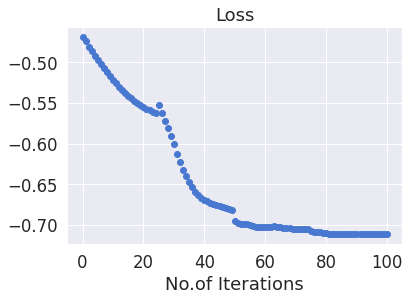

Avg Node Cluster Distance of Cluster  0  is  5.537399
Cluster  0  Center  [6.18142  0.844076]
Avg Node Cluster Distance of Cluster  1  is  3.1503372
Cluster  1  Center  [  3.643801 -16.598831]
Avg Node Cluster Distance of Cluster  2  is  3.5658522
Cluster  2  Center  [ 0.2665384 17.977058 ]
Avg Node Cluster Distance of Cluster  3  is  0.61710817
Cluster  3  Center  [  0.24390642 -24.191168  ]
1   17.62653
2   18.125256
3   25.729702
0   17.62653
2   34.74044
3   8.318826
0   18.125256
1   34.74044
3   42.168232
0   25.729702
1   8.318826
2   42.168232


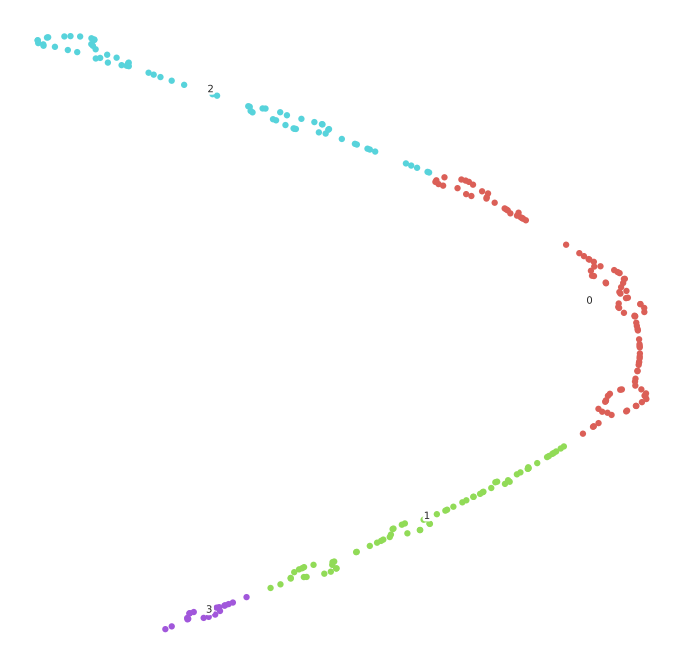

In [104]:
plt.scatter(list(range(len(Loss))),Loss)
plt.title("Loss")
plt.xlabel("No.of Iterations")
plt.show()

fashion_tsne = TSNE(random_state=0).fit_transform(Borrower_Emb)
fashion_scatter(fashion_tsne, training_kmeans.labels_)

In [105]:
# n = 0
# for i in Borrower_Emb:
#     print(i,"\n")
#     n += 1
#     if n == 3:
#         break

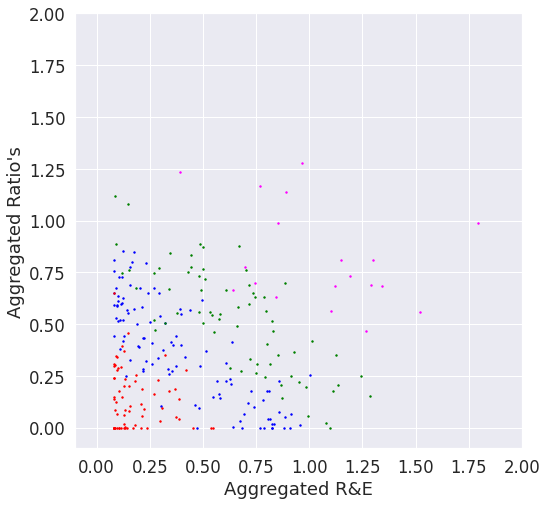

In [106]:
d = 1

Rev = my_agg_func([R_Att[1:],E_Att[1:]],d,'borrower')[np.where(training_kmeans.labels_ == 0)[0]]
Net = my_agg_func([NDE_Att[1:],TDE_Att[1:]],d,'borrower')[np.where(training_kmeans.labels_ == 0)[0]]


Rev2 = my_agg_func([R_Att[1:],E_Att[1:]],d,'borrower')[np.where(training_kmeans.labels_ == 1)[0]]
Net2 = my_agg_func([NDE_Att[1:],TDE_Att[1:]],d,'borrower')[np.where(training_kmeans.labels_ == 1)[0]]


Rev3 = my_agg_func([R_Att[1:],E_Att[1:]],d,'borrower')[np.where(training_kmeans.labels_ == 2)[0]]
Net3 = my_agg_func([NDE_Att[1:],TDE_Att[1:]],d,'borrower')[np.where(training_kmeans.labels_ == 2)[0]]


Rev4 = my_agg_func([R_Att[1:],E_Att[1:]],d,'borrower')[np.where(training_kmeans.labels_ == 3)[0]]
Net4 = my_agg_func([NDE_Att[1:],TDE_Att[1:]],d,'borrower')[np.where(training_kmeans.labels_ == 3)[0]]

plt.figure(figsize = (8,8))
plt.scatter(-Rev,Net,s = 2,c = np.array(['blue']))
plt.scatter(-Rev2,Net2, s= 2, c = np.array(['green']))
plt.scatter(-Rev3,Net3, s = 2, c = np.array(['red']))
plt.scatter(-Rev4,Net4, s = 2, c= np.array(['magenta']))

plt.xlim(-0.1,2)
plt.ylim(-0.1,2)
plt.ylabel("Aggregated Ratio's")
plt.xlabel("Aggregated R&E")
plt.show()

In [107]:
PS1_1 = []
PS2_1 = []
PS3_1 = []
PS4_1 = []

for i in range(len(training_kmeans.labels_)):
    if training_kmeans.labels_[i] == 0:
        PS1_1.append(i)
    elif training_kmeans.labels_[i] == 1:
        PS2_1.append(i)
    elif training_kmeans.labels_[i] == 2:
        PS3_1.append(i)
    elif training_kmeans.labels_[i] == 3:
        PS4_1.append(i)

n = 0
m = 0
p = 0
q = 0
r = 0

ID_Green = []
ID_Blue = []
ID_Red = []
ID_Magenta = []
for i in Five_Year_Data_Set_N.items():
    ID,data = i
    if n in PS1_1:
        ID_Blue.append(ID)
        if m < 10:
#             print('Blue',data['Sector'],'Revenue ',data['Revenue'],'EBITDA',data['EBITDA'],
#                   'NDE ',list(np.round(np.array(data['NDE']),2)),'TDE ',list(np.round(np.array(data['TDE']),2)))
            m += 1
        
    if n in PS2_1:
        ID_Magenta.append(ID)
        if p < 5:
            #print('PS2',data['Sector'],data['Revenue'],data['EBITDA'],data['NDE'],data['TDE'])
            p += 1

    if n in PS3_1:
        ID_Red.append(ID)
        if q < 10:
#             print('Green',data['Sector'],'Revenue ',data['Revenue'],'EBITDA',data['EBITDA'],
#                   'NDE ',list(np.round(np.array(data['NDE']),2)),'TDE ',list(np.round(np.array(data['TDE']),2)))
            q += 1

    if n in PS4_1:
        ID_Green.append(ID)
        if r < 5:
            #print('PS3',data['Sector'],data['Revenue'],data['EBITDA'],data['NDE'],data['TDE'])
            r += 1
            
#     sector_rev += np.array(data['Revenue'])    
    n += 1

%store ID_Green
%store ID_Red
%store ID_Blue
%store ID_Magenta

Stored 'ID_Green' (list)
Stored 'ID_Red' (list)
Stored 'ID_Blue' (list)
Stored 'ID_Magenta' (list)


69 30 71 93


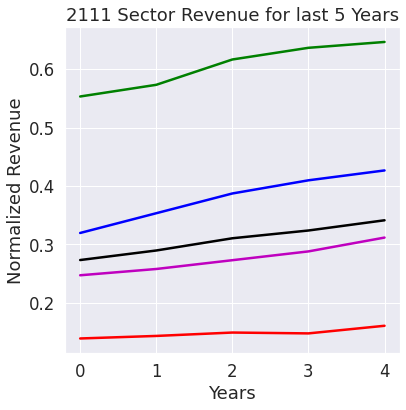

In [61]:
PS1_1 = []
PS2_1 = []
PS3_1 = []
PS4_1 = []

for i in range(len(training_kmeans.labels_)):
    if training_kmeans.labels_[i] == 0:
        PS1_1.append(i)
    elif training_kmeans.labels_[i] == 1:
        PS2_1.append(i)
    elif training_kmeans.labels_[i] == 2:
        PS3_1.append(i)
    elif training_kmeans.labels_[i] == 3:
        PS4_1.append(i)
    
#print(PS1_1,PS2_1,PS3_1)
        
Psector1_rev_1 = np.array([0.,0.,0.,0.,0.])
Psector2_rev_1 = np.array([0.,0.,0.,0.,0.])
Psector3_rev_1 = np.array([0.,0.,0.,0.,0.])
Psector4_rev_1 = np.array([0.,0.,0.,0.,0.])
sector_rev = np.array([0.,0.,0.,0.,0.])
n = 0
m = 0
p = 0
q = 0
r = 0
for i in Five_Year_Data_Set_N.items():
    ID,data = i
    if n in PS1_1:
        #print(data['Sector'],data['Revenue'],data['EBITDA'],data['NDE'],data['TDE'])
        Psector1_rev_1 += np.array(data['Revenue'])
        m += 1
    if n in PS2_1:
        #print(data['Sector'],data['Revenue'],data['EBITDA'],data['NDE'],data['TDE'])
        Psector2_rev_1 += np.array(data['Revenue'])
        p += 1
    if n in PS3_1:
        #print(data['Sector'],data['Revenue'],data['EBITDA'],data['NDE'],data['TDE'])
        Psector3_rev_1 += np.array(data['Revenue'])
        q += 1
    if n in PS4_1:
        #print(data['Sector'],data['Revenue'],data['EBITDA'],data['NDE'],data['TDE'])
        Psector4_rev_1 += np.array(data['Revenue'])
        r += 1
    
    sector_rev += np.array(data['Revenue'])    
    n += 1
    
Psector1_rev_1 = Psector1_rev_1/m
Psector2_rev_1 = Psector2_rev_1/p
Psector3_rev_1 = Psector3_rev_1/q
Psector4_rev_1 = Psector4_rev_1/r
print(m,p,q,r)
sector_rev = sector_rev/n

for i in Five_Year_Data_Set_N.values():
    sector_name = i['Sector']
    break
    
plt.figure(figsize = (6,6))
S, = plt.plot(range(len(sector_rev)),sector_rev,'k')
ps1, = plt.plot(range(len(Psector1_rev_1)),Psector1_rev_1,'r')
ps2, = plt.plot(range(len(Psector2_rev_1)),Psector2_rev_1,'g')
ps3, = plt.plot(range(len(Psector3_rev_1)),Psector3_rev_1,'b')
ps4, = plt.plot(range(len(Psector4_rev_1)),Psector4_rev_1,'m')
#plt.legend([S,ps1,ps2,ps3,ps4],[ 'Sector '+str(n_borrowers), 'PS1', 'PS2', 'PS3', 'PS4'])
plt.title(sector_name + " Sector Revenue for last 5 Years")
plt.xlabel("Years")

plt.ylabel("Normalized Revenue")
plt.show()

In [21]:
# Data_Dict = Pandas_to_Dict(sector_data)

In [62]:
# n = 0
# for i in Data_Dict.items():
#     print(i,"\n")
#     n += 1
#     if n == 3:
#         break

In [63]:
# print(len(Data_Dict))

In [64]:
# l = []
# for i in Data_Dict.items():
#     ID,data = i
#     if len(data['Revenue']) < 5 or len(data['EBITDA']) < 5 or len(data['NDE']) < 5 or len(data['TDE']) < 5:
#         l.append(ID)
        
# print(len(l))

# for i in l:
#     Data_Dict.pop(i)

# print(len(Data_Dict))


# n = 0
# for i in Data_Dict.items():
#     print(i,"\n")
#     n += 1
#     if n == 3:
#         break

In [65]:
# FYear_Data_Dict = {}
# for i in Data_Dict.items():
#     ID,data = i
#     FYear_Data_Dict[ID] = {}
#     FYear_Data_Dict[ID]['Sector'] = data['sector']
#     FYear_Data_Dict[ID]['Revenue'] = data['Revenue'][:20][::-1]
#     FYear_Data_Dict[ID]['EBITDA'] = data['EBITDA'][:20][::-1]
#     FYear_Data_Dict[ID]['NDE'] = data['NDE'][:20][::-1]
#     FYear_Data_Dict[ID]['TDE'] = data['TDE'][:20][::-1]

    
# n = 0
# for i in FYear_Data_Dict.items():
#     print(i,"\n")
#     n += 1
#     if n == 3:
#         break

In [66]:
# l = []
# Time_Dict = {}
# for i in FYear_Data_Dict.items():
#     ID,data = i
    
#     R_time = []
#     for j in data['Revenue']:
#         R_time.append(j[0])
        
#     E_time = []
#     for j in data['EBITDA']:
#         E_time.append(j[0])
        
#     N_time = []
#     for j in data['NDE']:
#         N_time.append(j[0])
    
#     T_time = []
#     for j in data['TDE']:
#         T_time.append(j[0])
        
#     lis = list(set(R_time) & set(E_time) & set(N_time) & set(T_time))
#     lis.sort()
#     Time_Dict[ID] = lis
    
# print(len(Time_Dict))

# n = 0
# for i in Time_Dict.items():
#     print(i,"\n")
#     n += 1
#     if n == 5:
#         break

In [67]:
# l = []
# for i in Time_Dict.items():
#     ID,time = i
#     if len(time) < 5:
#         l.append(ID)
        
# for i in l:
#     Time_Dict.pop(i)

# print(len(Time_Dict))

# n = 0
# for i in Time_Dict.items():
#     print(i,"\n")
#     n += 1
#     if n == 5:
#         break

In [68]:
# Five_Year_Data_Dict = {}
# for i in Time_Dict.items():
#     ID,time = i
#     data = FYear_Data_Dict[ID]
#     Five_Year_Data_Dict[ID] = {}
#     Five_Year_Data_Dict[ID]['Sector'] = data['Sector']
    
#     Five_Year_Data_Dict[ID]['R'] = []
#     for j in time[:5]:
#         for p in data['Revenue']:
#             if j == p[0]:
#                 Five_Year_Data_Dict[ID]['R'].append(p[1])
    
#     Five_Year_Data_Dict[ID]['EBITDA'] = []
#     for j in time[:5]:
#         for p in data['EBITDA']:
#             if j == p[0]:
#                 Five_Year_Data_Dict[ID]['EBITDA'].append(p[1])
                
#     Five_Year_Data_Dict[ID]['NDE'] = []
#     for j in time[:5]:
#         for p in data['NDE']:
#             if j == p[0]:
#                 Five_Year_Data_Dict[ID]['NDE'].append(p[1])
                
#     Five_Year_Data_Dict[ID]['TDE'] = []
#     for j in time[:5]:
#         for p in data['TDE']:
#             if j == p[0]:
#                 Five_Year_Data_Dict[ID]['TDE'].append(p[1])
                
                
    
# n = 0
# for i in Five_Year_Data_Dict.items():
#     print(i,"\n")
#     n += 1
#     if n == 5:
#         break 
        
# print(len(Five_Year_Data_Dict))